## Multi-agent Network
In Multi-agent Network each agent can communicate with every other agent. Any agent can decide which other agent to call next.

This project demonstrates a **multi-agent system architecture** using **LangGraph**, inspired by the *AutoGen* paper: https://arxiv.org/abs/2308.08155 

The goal is to showcase how complex tasks can be **decomposed and distributed** among specialized agents, each equipped with specific tools. In this example, the task is to:
- **Research** the UK's GDP over the past 5 years.
- **Generate a line chart** based on the data.

To achieve this, the system uses two collaborative agents:
- A **Research Agent** that performs web searches using the **Tavily API**.
- A **Chart Generator Agent** that executes Python code to create visualizations.

These agents communicate through a **graph-based workflow**, passing messages and results until the task is completed. This modular design allows each agent to focus on its domain while contributing to a shared objective.

---

#### **Code Structure & Workflow**
The code follows a **modular and sequential pipeline**:

1. **Setup**  
   - Installs required packages.
   - Configures API keys for Tavily and Anthropic.
   - Optionally integrates with **LangSmith** for debugging and monitoring.

2. **Tool Definition**  
   - Defines tools like `TavilySearchResults` for web search and `PythonREPL` for executing Python code.
   - Wraps the Python execution in a safe callable tool.

3. **Agent Nodes**  
   - Creates two agents using `create_react_agent`:
     - **Research Agent**: Only performs research.
     - **Chart Generator Agent**: Only generates charts.
   - Each agent is given a **system prompt** to define its role and behavior.
   - Nodes are defined to manage agent invocation and message passing.

4. **Graph Construction**  
   - Uses `StateGraph` to define the workflow.
   - Connects the agents in a loop, starting with the researcher and alternating until a **"FINAL ANSWER"** is produced.

5. **Invocation**  
   - The graph is invoked with a user query.
   - The system streams the interaction between agents step-by-step, showing how they collaborate to complete the task.

# Import Required Libraries

In [16]:

import time, requests, os
from langchain.agents import AgentExecutor, create_openai_functions_agent, create_openai_tools_agent, create_tool_calling_agent
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage, AnyMessage
from langchain_core.prompts import PromptTemplate
from langchain.agents import AgentExecutor, tool, create_react_agent
from langchain_core.tools import tool
from langchain.tools import Tool
from langchain_core.messages.tool import ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.utilities import PythonREPL
from langchain.schema import HumanMessage, SystemMessage, AIMessage
import functools
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
#from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, MessagesState, END
from langgraph.types import Command
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages




from typing import List, Dict
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from ias_openai_langchain import IASOpenaiConversationalLLM
from llm import VoxLLM
from ias_openai_langchain_old import IASOpenaiConversationalLLM, IASOpenaiEmbeddings

# from langchain_openai import ChatOpenAI
# from dotenv import load_dotenv

In [17]:
MASTER_USER = "8bc3cc94aaad42169c5fd6fbd63ffb2f"
MASTER_PASS = "0ad756CbaE9A4629af86F5356Ac65be8"
IAS_OPENAI_CHAT_URL="https://mule4api-comm-amer-dev.pfizer.com/vessel-openai-api-v1/chatCompletion"


def auth_credentials():
    """
    Generate authentication token from devfederate.
    """
    post = requests.post("https://devfederate.pfizer.com/as/token.oauth2?grant_type=client_credentials", auth=(MASTER_USER, MASTER_PASS)).json()
    return post['access_token']

In [18]:
# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [19]:
# Initialize the Language Model
federated_token = auth_credentials()

llm = VoxLLM(model='gpt-4o',
            max_tokens=4096,
            temperature=0.2)

In [20]:
# import getpass
# import os


# def _set_if_undefined(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"Please provide your {var}")


# _set_if_undefined("ANTHROPIC_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

In [21]:
# Defines tool `TavilySearchResults` for web search

os.environ["TAVILY_API_KEY"] = "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"
tavily_tool = TavilySearchResults(max_results=2)
tavily_tool.invoke("What's a 'node' in LangGraph?")

[{'title': 'Next LangGraph Glossary - Overview',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).\nSimilar to NetworkX, you add these nodes to a graph using the add_node method:\n[](https://langchain-ai.github.io/langgraph/concepts/low_level/#__codelineno-7-1)fromlangchain_core.runnablesimport RunnableConfig [...] LangGraph Glossary¶\nGraphs¶\nAt its core, LangGraph models agent workflows as graphs. You define the behavior of your agents using three key components:\n\n\nState: A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.\n\n\nNodes: Python functions that encode the logic of your agents. They

In [22]:
# Defines tool `PythonREPL` for executing Python code
# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

<>:17: SyntaxWarning: invalid escape sequence '\`'
<>:17: SyntaxWarning: invalid escape sequence '\`'
<>:17: SyntaxWarning: invalid escape sequence '\`'
<>:17: SyntaxWarning: invalid escape sequence '\`'
C:\Users\RASHIF02\AppData\Local\Temp\1\ipykernel_4404\2145527124.py:17: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\RASHIF02\AppData\Local\Temp\1\ipykernel_4404\2145527124.py:17: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


### Create graph
We've defined our tools and made some helper functions, now we will create the individual agents below and tell them how to talk to each other using LangGraph.

In [23]:
# from langchain_core.prompts import PromptTemplate

# def make_system_prompt(suffix: str) -> PromptTemplate:
#     prompt_template = (
#         "You are a helpful AI assistant, collaborating with other assistants.\n"
#         "Use the following tools to help you:\n{tools}\n\n"
#         "You can use these tools: {tool_names}\n\n"
#         "Use the provided tools to progress towards answering the question.\n"
#         "If you are unable to fully answer, that's OK — another assistant with different tools "
#         "will help where you left off. Execute what you can to make progress.\n"
#         "If you or any of the other assistants have the final answer or deliverable, "
#         "prefix your response with FINAL ANSWER so the team knows to stop.\n\n"
#         "{agent_scratchpad}\n"
#         f"{suffix}"
#     )
#     return PromptTemplate.from_template(prompt_template)


In [24]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

#### Routing Utility  
This helper function is a routing utility used in the multi-agent graph. 
It decides what the next step in the workflow should be, based on the content of the last message exchanged between agents.

- If the message contains "FINAL ANSWER", it means one of the agents has completed the task, so the function returns END, signaling the graph to stop.
- If not, it returns the goto value, which tells the graph which agent node to activate next (e.g., switch from researcher to chart generator or vice versa).

In [25]:
# Define routing utility helper function
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [26]:
# Define Research Agent and Node:

# Research agent
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


# Research node
def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [27]:
# Define Chart Generator Agent and Node

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED


# Chart Generator agent
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


# Chart Generator node
def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [28]:
# Define the Graph
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

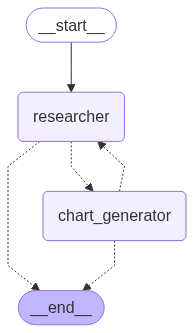

In [29]:
# Display the Graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [30]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='0593602e-2322-4f47-b674-f636ec352102'), AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query":"UK GDP data for the past 5 years"}', 'name': 'tavily_search_results_json'}, 'id': 'call_75uzmjNZtGewid4eKQ3U4Sb3', 'type': 'function'}]}, response_metadata={'usage_metadata': {'total_tokens': 235, 'completion_tokens': 208, 'prompt_tokens': 27}, 'model_name': 'gpt-4o', 'finish_reason': 'stop'}, id='run-37e79092-9494-4140-8a45-4b827429b596-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP data for the past 5 years'}, 'id': 'call_75uzmjNZtGewid4eKQ3U4Sb3', 'type': 'tool_call'}]), ToolMessage(content='[{"title": "United Kingdom GDP - Trading Economics", "url": "https://tradingeconomics.com/united-kingdom/gdp", "content":

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='0593602e-2322-4f47-b674-f636ec352102'), AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query":"UK GDP data for the past 5 years"}', 'name': 'tavily_search_results_json'}, 'id': 'call_75uzmjNZtGewid4eKQ3U4Sb3', 'type': 'function'}]}, response_metadata={'usage_metadata': {'total_tokens': 235, 'completion_tokens': 208, 'prompt_tokens': 27}, 'model_name': 'gpt-4o', 'finish_reason': 'stop'}, id='run-37e79092-9494-4140-8a45-4b827429b596-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP data for the past 5 years'}, 'id': 'call_75uzmjNZtGewid4eKQ3U4Sb3', 'type': 'tool_call'}]), ToolMessage(content='[{"title": "United Kingdom GDP - Trading Economics", "url": "https://tradingeconomics.com/united-kingdom/gdp", "cont



#### **What Is a Multi-Agent Network?**

A **multi-agent network** is a system where **multiple autonomous agents** (often AI models or modules) work **collaboratively or in parallel** to solve a complex task. Each agent typically has a **specialized role**, and they **communicate** or **pass information** to each other to complete the overall objective.

---

1. **Multiple Agents Defined**  
   You see more than one agent being created, each with its own tools, prompts, or responsibilities.  
   _Example: One agent does research, another generates charts._

2. **Task Specialization**  
   Each agent is assigned a **specific sub-task** or domain.  
   _Example: One agent only searches the web, another only executes Python code._

3. **Communication Between Agents**  
   Agents **pass messages or state** to each other, often through a shared memory or graph structure.  
   _Example: The research agent sends data to the chart agent._

4. **Graph or Workflow Structure**  
   The system uses a **graph or flow-based model** (like LangGraph) to define how agents interact and in what order.  
   _Example: A `StateGraph` defines transitions between agents._

5. **Coordination Logic**  
   There’s logic to decide **when to stop** or **which agent to activate next**, often based on message content (e.g., checking for `"FINAL ANSWER"`).

---

### In this project

Your system **is a multi-agent network** because:

- You have **two agents**: a **researcher** and a **chart generator**.
- Each agent has a **distinct role** and toolset.
- They **communicate via a shared message state**.
- A **LangGraph workflow** coordinates their interaction.
- The system uses a **looping structure** to alternate between agents until the task is complete.